#### Example running SpaFHy with jupyter notebook

In [1]:
from model_driver import driver
from iotools import read_results
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os

#os.chdir(r'/projappl/project_2000908/nousu/SpaFHy_v2.0')
os.chdir(r'/Users/jpnousu/SpaFHy_v2.0')

# example of calling driver, reading results
#outputfile = driver(create_ncf=True, create_spinup=False, folder='/Users/jpnousu/SpaFHy_RUNS/krycklan')
outputfile = driver(create_ncf=True, create_spinup=False, folder='/Users/jpnousu/SpaFHy_RUNS/hyytiala')
results = xr.open_dataset(outputfile)

/Users/jpnousu/SpaFHy_RUNS/hyytiala/gis_32_vmi/catchment_mask_all.asc
/Users/jpnousu/SpaFHy_RUNS/hyytiala/gis_32_vmi/stream_mask.asc
/Users/jpnousu/SpaFHy_RUNS/hyytiala/gis_32_vmi/lake_mask.asc
/Users/jpnousu/SpaFHy_RUNS/hyytiala/gis_32_vmi/top_soil.asc
/Users/jpnousu/SpaFHy_RUNS/hyytiala/gis_32_vmi/site_type_combined.asc
/Users/jpnousu/SpaFHy_RUNS/hyytiala/gis_32_vmi/canopy_height.asc
/Users/jpnousu/SpaFHy_RUNS/hyytiala/gis_32_vmi/canopy_fraction.asc
/Users/jpnousu/SpaFHy_RUNS/hyytiala/gis_32_vmi/LAI_conif.asc
/Users/jpnousu/SpaFHy_RUNS/hyytiala/gis_32_vmi/LAI_decid.asc
/Users/jpnousu/SpaFHy_RUNS/hyytiala/gis_32_vmi/low_soil.asc
/Users/jpnousu/SpaFHy_RUNS/hyytiala/gis_32_vmi/dem.asc
/Users/jpnousu/SpaFHy_RUNS/hyytiala/gis_32_vmi/stream_mask.asc
/Users/jpnousu/SpaFHy_RUNS/hyytiala/gis_32_vmi/lake_mask.asc
*** Defined root soil IDs: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17} Used root soil IDs: {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0} ***
**

/Users/jpnousu/SpaFHy_v2.0/canopygrid.py:759: RuntimeWarning: invalid value encountered in arccos
  dl = 2.0*np.arccos(cosZEN - np.sin(LAT)*np.sin(DECL) / (np.cos(LAT)*np.cos(DECL))) / CF / 15.0  # hours


Timestep: 1 iterations 16 0.0009419230522667021 -0.008703011885842216
Running timestep:  2


/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:279: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)


Timestep: 2 iterations 19 0.0007761918203925688 -0.009194163160572089
Running timestep:  3
Timestep: 3 iterations 32 0.0009758679912863499 -0.010222662359751666
Running timestep:  4
	 91 0.015545733410874618 (162, 280) 0.0 -0.013931751233229761
	 92 0.011113136178153127 (162, 280) 0.0 -0.016710035277753832
	 93 0.008115482221029424 (162, 280) 0.0 -0.018738905833004083
	 94 0.006010382544360482 (162, 280) 0.0 -0.020241501469087098
	 95 0.00447796204642259 (162, 280) 0.0 -0.02136099198071406
	 96 0.003290525627335228 (162, 280) 0.0 -0.02218362338754787
	 97 0.002583133178859498 (109, 257) 0.0 -0.010915194704580244
	 98 0.002566438759885159 (39, 319) 0.0 -0.010796908548968531
	 99 0.004004384380522197 (125, 266) 0.0 -0.010935955286754506
Timestep: 4 iterations 99 0.004004384380522197 -0.010935955286754506
Running timestep:  5
Timestep: 5 iterations 66 0.0008519305637264551 -0.009955656148491698
*** Writing results to netCDF4-file, subset 1/1 ***
--- Running time 230.56 seconds ---
--- Res

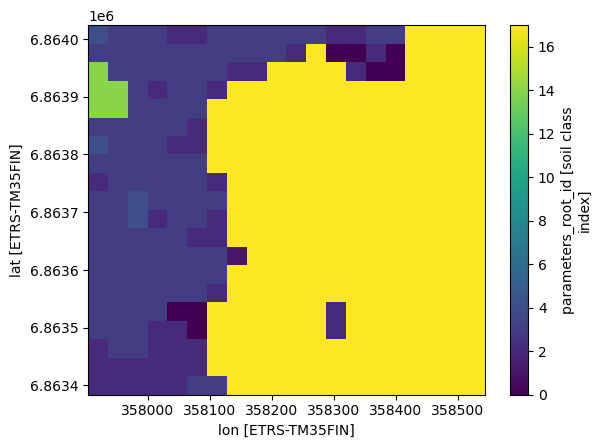

In [11]:
results['parameters_root_id'][30:50, 310:330].plot()

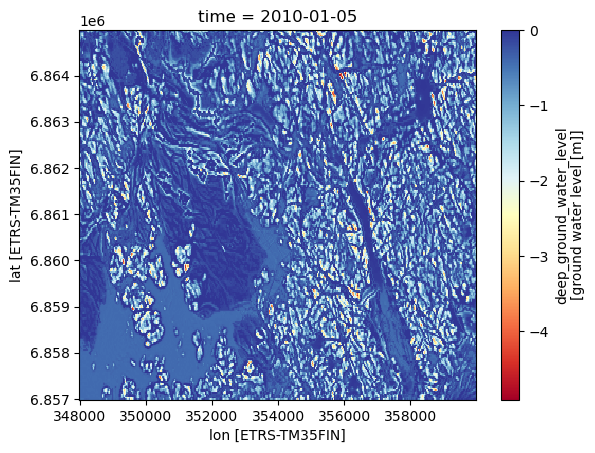

In [5]:
#results['deep_ground_water_level'][-1, 120:180,250:300].plot(cmap='RdYlBu')
results['deep_ground_water_level'][-1].plot(cmap='RdYlBu')

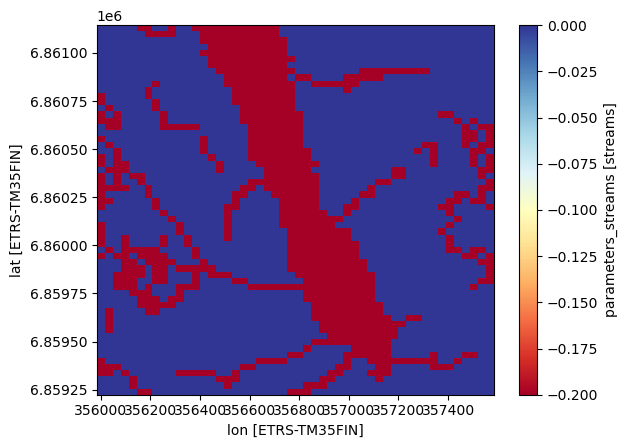

In [4]:
results['parameters_streams'][120:180,250:300].plot(cmap='RdYlBu')

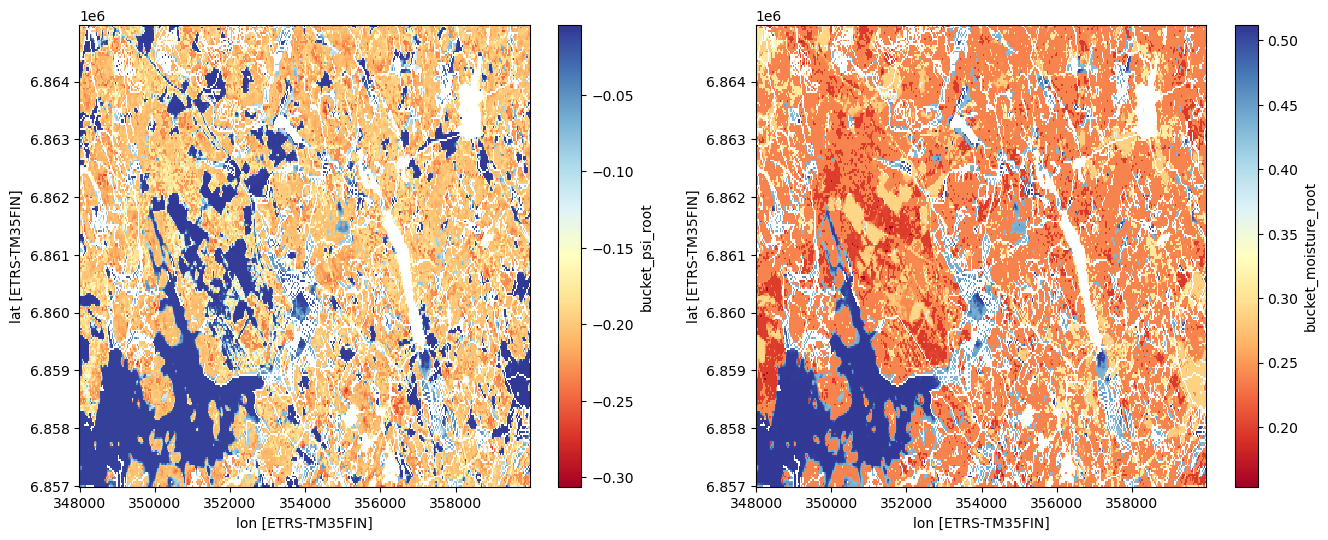

In [2]:
date = '2020-08-01'
plt.figure(figsize=(16,6))
ax=plt.subplot(1,2,1)
#results['bucket_psi_root'].sel(time=date).plot(cmap='coolwarm_r')
results['bucket_psi_root'].mean(dim=['time']).plot(cmap='RdYlBu')
plt.subplot(1,2,2, sharex=ax, sharey=ax)
#results['bucket_moisture_root'].sel(time=date)[20:-60,70:-100].plot(cmap='coolwarm_r')
results['bucket_moisture_root'].mean(dim=['time']).plot(cmap='RdYlBu')
#results['bucket_moisture_root'].sel(time=date).plot(cmap='coolwarm_r')
#plt.subplot(1,2,3, sharex=ax, sharey=ax)
#plt.subplot(2,2,4, sharex=ax, sharey=ax)
#results['bucket_moisture_top'].sel(time=date)[20:-60,70:-100].plot(cmap='coolwarm_r')

In [ ]:
import xarray as xr
file = r'/scratch/project_2000908/nousu/SpaFHy_RESULTS/testcase_input_202403121454.nc'
results = xr.open_dataset(file)

In [ ]:
firedata = results[['forcing_wind_speed', 'forcing_air_temperature', 'forcing_relative_humidity', 
                    'bucket_psi_root']].copy()
results.close()

In [ ]:
# subset by month
firedatass = firedata.sel(time=firedata.time.dt.month.isin([5, 6, 7, 8, 9])).copy()
# subset by snow
#firedatass = firedata.sel(time=(results['canopy_snow_water_equivalent'].max(dim=['lat','lon']) == 0)).copy()

In [ ]:
firedatass['forcing_wind_speed'][:].plot()

In [ ]:
fp = r'/scratch/project_2000908/nousu/SpaFHy_RESULTS/spafhy_for_fire_3_24.nc'
firedatass.to_netcdf(fp, 'w')
firedatass.close()